# Creation of the Data
---

We will create syntetic time series data for different purposes.  
First, we want to make sure that the response is dependent of other variables, commonly named **process variables**.  
Second, we want to make sure that the response has some gaussian noise induced.  

In [3]:
import time
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from timeseries import WindowSlider

This is saying Package imported because I inserted the timeseries.py script into the site-packages folder of my AI environment. Thus, I can bring WindowSlider class and create objects that will inherit this class.

In [4]:
np.random.seed(2018)

<function matplotlib.pyplot.show>

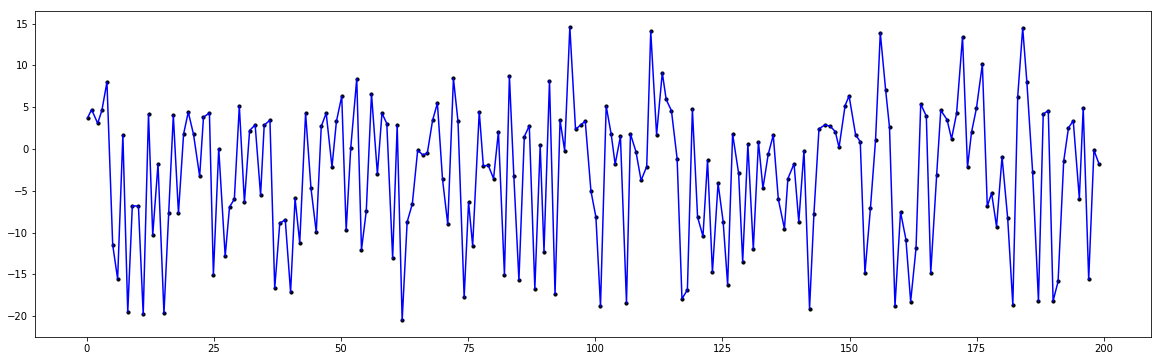

In [5]:
##############################################################################
# Data Creation
##############################################################################

t = np.arange(0, 200, 1).reshape(-1,1)
t = np.array([t[i] + np.random.rand(1)/4 for i in range(len(t))])
t = np.array([t[i] - np.random.rand(1)/7 for i in range(len(t))])
t = np.array(np.round(t, 2))

x1 = np.round((np.random.random(200) * 5).reshape(-1,1), 2)
x2 = np.round((np.random.random(200) * 5).reshape(-1,1), 2)
x3 = np.round((np.random.random(200) * 5).reshape(-1,1), 2)

n = np.round((np.random.random(200) * 2).reshape(-1,1), 2)

y = np.array([((x1[t] - x2[t-1]**2) + 0.02*x3[t-3]*np.exp(x1[t-1])) for t in range(len(t))])
y = np.round(y+n, 2)

plt.figure(figsize=(20,6))
plt.plot(t, y, 'b-')
plt.scatter(t, y, color='black', s=10)
plt.show


We can see how are response y looks random, but we know it is just a combination of two predicted random variables x1 and x2 with some normal noise. Also, note that the time series is not evenly spaced, which is a more general approach to real life problems.  

Now, we will incorporate ∆T into our dataframe. As we have discussed, we want to build standard windows for e ery observation. Therefore we are intereseted in the elapsed time between observations rather that its absolute values. To better understand this, we say that for us, two points at timestamps (10, 15) are the same as other two at (20, 25), we just care they are 5 seconds spaced.

In [10]:
##############################################################################
# Creation of ∆T
##############################################################################

dataset = pd.DataFrame(np.concatenate((t, x1, x2, x3, y), axis=1), 
                       columns=['t', 'x1', 'x2', 'x3', 'y'])


deltaT = np.array([(dataset.t[i + 1] - dataset.t[i]) for i in range(len(dataset)-1)])
deltaT = np.concatenate((np.array([0]), deltaT))
print('Mean ∆t: %.2f' % np.mean(deltaT))
print('Median ∆t: %.2f' % np.median(deltaT))

dataset.insert(1, '∆t', deltaT)
limit = int(len(dataset)*0.8)

trainset = dataset.iloc[dataset.index < limit]
testset = dataset.iloc[dataset.index >= limit]

trainset.head(5)

Mean ∆t: 0.99
Median ∆t: 1.00


,t,∆t,x1,x2,x3,y
0,0.18,0.00,3.74,0.98,3.48,3.73
1,0.96,0.78,1.82,0.40,2.90,4.72
2,2.16,1.20,1.02,0.66,2.79,3.07
3,2.98,0.82,4.75,0.60,1.38,4.61
4,3.98,1.00,1.52,3.80,3.38,8.00


Now we can use our class WindowSlider to create our windows.  
We will create two kind of windows to evaluate the effect of considering or not, previous values of y to predict its own future values.

In [11]:
##############################################################################
# Creation of the Windows
##############################################################################
train_constructor = WindowSlider()
train_windows = train_constructor.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=False)

test_constructor = WindowSlider()
test_windows = test_constructor.collect_windows(testset.iloc[:,1:],
                                                previous_y=False)

train_constructor_y_inc = WindowSlider()
train_windows_y_inc = train_constructor_y_inc.collect_windows(trainset.iloc[:,1:], 
                                                  previous_y=True)

test_constructor_y_inc = WindowSlider()
test_windows_y_inc = test_constructor_y_inc.collect_windows(testset.iloc[:,1:],
                                                previous_y=True)

train_windows.head(3)

,∆t(1),∆t(2),∆t(3),∆t(4),∆t(5),x1(1),x1(2),x1(3),x1(4),x1(5),...,x2(3),x2(4),x2(5),x3(1),x3(2),x3(3),x3(4),x3(5),∆t(6),Y
0,0.0,0.78,1.98,2.80,3.80,3.74,1.82,1.02,4.75,1.52,...,0.66,0.60,3.80,3.48,2.90,2.79,1.38,3.38,4.93,-11.47
1,0.0,1.20,2.02,3.02,4.15,1.82,1.02,4.75,1.52,0.72,...,0.60,3.80,4.24,2.90,2.79,1.38,3.38,0.53,5.12,-15.55
2,0.0,0.82,1.82,2.95,3.92,1.02,4.75,1.52,0.72,0.55,...,3.80,4.24,0.88,2.79,1.38,3.38,0.53,1.62,4.95,1.66


We can see how the windows brings for every prediction, the records of the (window_length) time steps in the past of the rest of the variables, and the accumulative sum of ∆t.

### Exporting the windows
---
In order to not to have to create the windows for every approach, we can save our windows and just import them when needed.  

There are two possible ways (among many others) to do that.  

First, we can export an Excel file. The advantage is that we can quickly have a look at our windows at any moment, or give an easy acces to them to people that may not be familiared with programming or python.  

Second, we can export an HDFS file. The advantage of this is that is way faster to import into python through pandas than an Excel file.

In [13]:
# Export Windows to Excel
path_to_output = './windows_ts.xlsx'
writer = pd.ExcelWriter(path_to_output, engine='xlsxwriter')

dataset.to_excel(writer, sheet_name='dataset')
trainset.to_excel(writer, sheet_name='trainset')
testset.to_excel(writer, sheet_name='testset')
train_windows.to_excel(writer, sheet_name='train_windows')
test_windows.to_excel(writer, sheet_name='test_windows')
train_windows_y_inc.to_excel(writer, sheet_name='train_windows_y_inc')
test_windows_y_inc.to_excel(writer, sheet_name='test_windows_y_inc')

writer.save()

# Export Windows to H5
store = pd.HDFStore('./windows_ts.h5')
store['dataset']  = dataset
store['trainset']  = trainset
store['testset']  = testset
store['train_windows']  = train_windows
store['test_windows'] = test_windows
store['train_windows_y_inc']  = train_windows_y_inc
store['test_windows_y_inc'] = test_windows_y_inc
store.close()

# Baseline Models
---
```
"Always do the dummy thing first. Only apply intelligence when required"
Thad Starner
```
We need to first come up with models that does not require *'intelligence'*. Then we will have a benchmark to understand how good/bad we are implementing our ideas. We will start with 2 levels of *naive* approaches.

### Prediction = Current
---
We will first start with a simple model that will give the last value (the current one at each predicition point) as the prediction for the next timestamp.

In [25]:
# ________________ Y_pred = current Y ________________ # RMSE = 11.28
bl_trainset = cp.deepcopy(trainset)
bl_testset = cp.deepcopy(testset)

t0 = time.time()
bl_y = pd.DataFrame(bl_testset['y'])
bl_y_pred = bl_y.shift(periods=1)
tF = time.time()

bl_residuals = bl_y_pred - bl_y
bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
print('RMSE = %.2f' % bl_rmse)
print('Time to train = %.2f seconds' % (tF - t0))

RMSE = 11.28
Time to train = 0.00 seconds


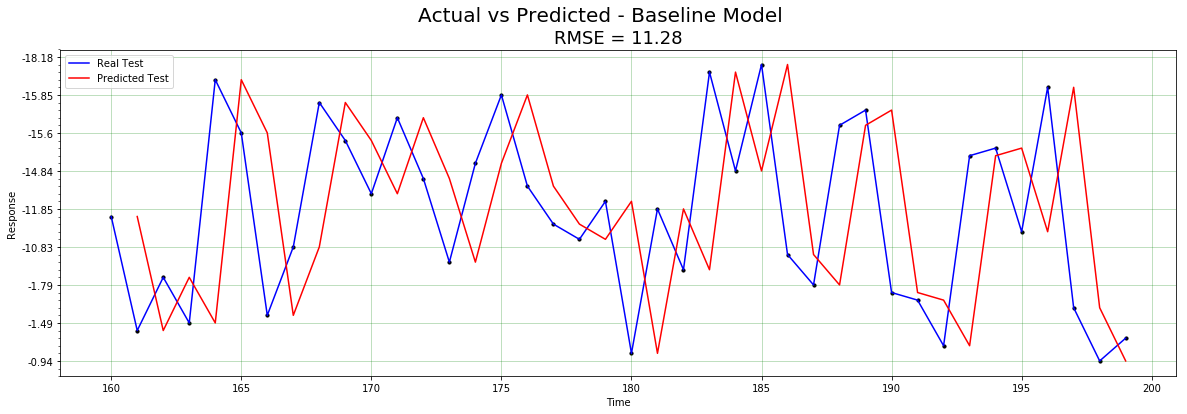

In [26]:
# Plot Predictions
def plot_bl():
    f, ax = plt.subplots(1, figsize=(20,6))
    plt.suptitle('Actual vs Predicted - Baseline Model' , fontsize=20)
    plt.title('RMSE = %.2f' % bl_rmse, fontsize = 18)
    plt.grid(color='green', linewidth=0.5, alpha=0.5)
    
    plt.scatter(bl_testset.index, bl_y, color='black', s=10)
    plt.plot(bl_testset.index, bl_y, color='b', label='Real Test')
    plt.plot(bl_testset.index, bl_y_pred, color='r', label='Predicted Test')
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    plt.xlabel('Time')
    plt.ylabel('Response')
    plt.legend()
    plt.show()

plot_bl()

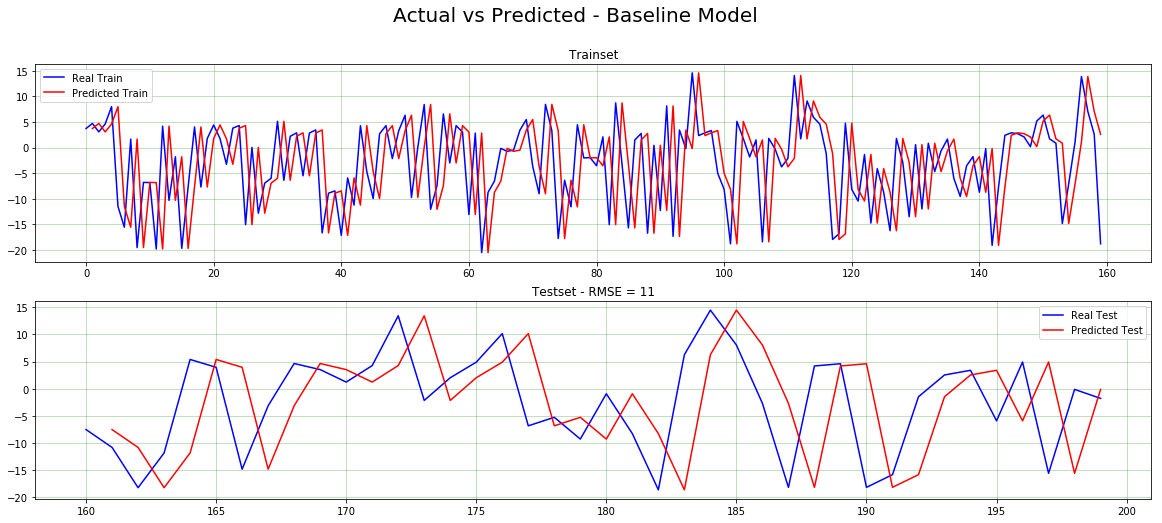

In [27]:
# Complete Plot
f, (ax1, ax2) = plt.subplots(2,1, figsize=(20,8))
plt.suptitle('Actual vs Predicted - Baseline Model' , fontsize=20)
ax1.grid(color='green', linewidth=0.5, alpha=0.5)
ax2.grid(color='green', linewidth=0.5, alpha=0.5)

ax1.plot(bl_trainset.index, bl_trainset['y'], color='b', label='Real Train')
ax1.plot(bl_trainset.index, bl_trainset['y'].shift(1), color='r', label='Predicted Train')
ax1.legend()
ax1.set_title('Trainset')

ax2.plot(bl_testset.index, bl_y, color='b', label='Real Test')
ax2.plot(bl_testset.index, bl_y_pred, color='r', label='Predicted Test')
ax2.set_title('Testset - RMSE = %2.f' % bl_rmse)
ax2.legend()

plt.show()    

**Conclusion**

## Multiple Linear Regression
---
Our next approach will be to build a multiple linear regression model

In [28]:
# ______________ MULTIPLE LINEAR REGRESSION ______________ # RMSE = 8.61
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(trainset.iloc[:,:-1], trainset.iloc[:,-1])

t0 = time.time()
lr_y = testset['y'].values
lr_y_fit = lr_model.predict(trainset.iloc[:,:-1])
lr_y_pred = lr_model.predict(testset.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))
print('RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))

RMSE = 8.61
Time to train = 0.00 seconds


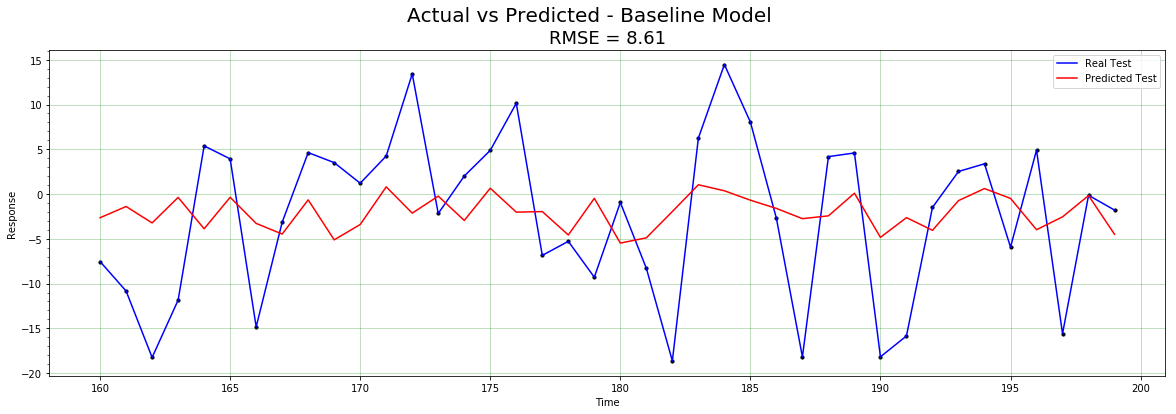

In [29]:
# Plot Predictions
def plot_lr():
    f, ax = plt.subplots(1, figsize=(20,6))
    plt.suptitle('Actual vs Predicted - Baseline Model' , fontsize=20)
    plt.title('RMSE = %.2f' % lr_rmse, fontsize = 18)
    plt.grid(color='green', linewidth=0.5, alpha=0.5)
    
    plt.scatter(testset.index, lr_y, color='black', s=10)
    plt.plot(testset.index, lr_y, color='b', label='Real Test')
    plt.plot(testset.index, lr_y_pred, color='r', label='Predicted Test')
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    plt.xlabel('Time')
    plt.ylabel('Response')
    plt.legend()
    plt.show()

plot_lr()

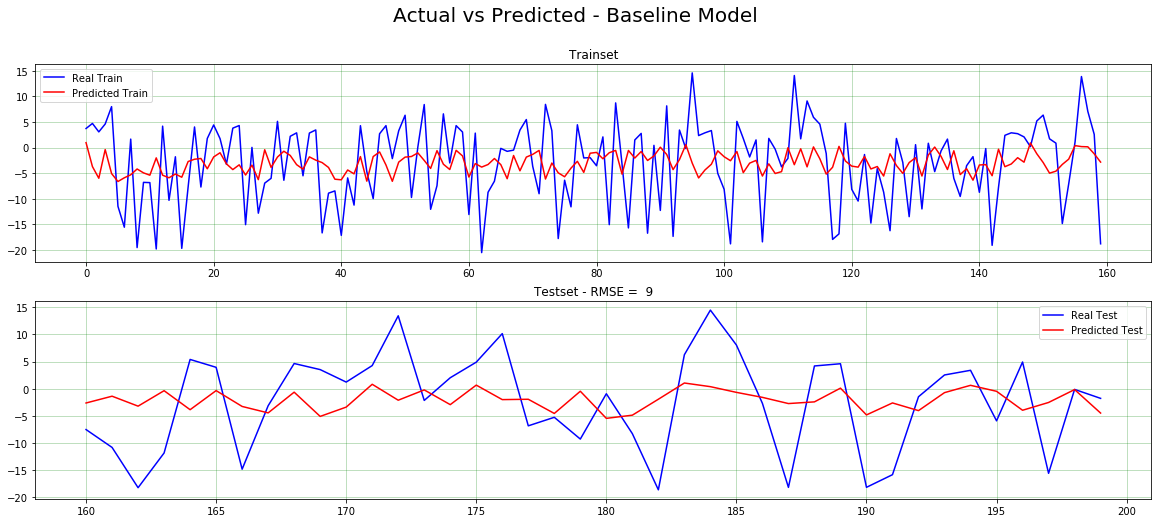

In [30]:
# Complete Plot
f, (ax1, ax2) = plt.subplots(2,1, figsize=(20,8))
plt.suptitle('Actual vs Predicted - Baseline Model' , fontsize=20)
ax1.grid(color='green', linewidth=0.5, alpha=0.5)
ax2.grid(color='green', linewidth=0.5, alpha=0.5)

ax1.plot(trainset.index, trainset['y'], color='b', label='Real Train')
ax1.plot(trainset.index, lr_y_fit, color='r', label='Predicted Train')
ax1.legend()
ax1.set_title('Trainset')

ax2.plot(testset.index, lr_y, color='b', label='Real Test')
ax2.plot(testset.index, lr_y_pred, color='r', label='Predicted Test')
ax2.set_title('Testset - RMSE = %2.f' % lr_rmse)
ax2.legend()

plt.show()    

**Conclusion**